In [1]:
import pandas as pd
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torchmetrics

Using backend: pytorch


## data preprocessing

In [145]:
# df = pd.read_csv('./kaggle_data(drug)/webmd.csv')
df = pd.read_feather('./webmd.ftr')
df.head()
print(df.shape)

(362806, 12)


### remove null data

In [3]:
df_ = df[df['Sides']!=' ']
df_.dropna(inplace=True)
df_

<ipython-input-3-9f6079ced774>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.dropna(inplace=True)


Age                      Condition        Date          Drug  \
0       75 or over                    Stuffy Nose   9/21/2014  25dph-7.5peh   
1            25-34                  Cold Symptoms   1/13/2011  25dph-7.5peh   
6            25-34                  Birth Control   6/15/2017     wymzya fe   
7            45-54  Disease of Ovaries with Cysts   1/30/2017     wymzya fe   
8            25-34                           Acne   4/27/2016     wymzya fe   
...            ...                            ...         ...           ...   
362801       55-64                   Stop Smoking  11/14/2008       chantix   
362802                                      Other  11/14/2008       chantix   
362803       25-34                   Stop Smoking  11/13/2008       chantix   
362804       55-64                   Stop Smoking  11/13/2008       chantix   
362805       45-54                   Stop Smoking  11/12/2008       chantix   

        DrugId  EaseofUse  Effectiveness  \
0       146724          5              5   
1       146724          5              5   
6       163180          5              5   
7       163180          5              5   
8       163180          4              2   
...        ...        ...            ...   
362801  144470          5              5   
362802  144470          2              3   
362803  144470          2              4   
362804  144470          5              5   
362805  144470          4              5   

                                                  Reviews  Satisfaction  \
0       I'm a retired physician and of all the meds I ...             5   
1       cleared me right up even with my throat hurtin...             5   
6       Haven't gotten pregnant so it does it's job. I...             2   
7       I have take this for 5 years age 45-50 to prev...             5   
8                                                                     2   
...                                                   ...           ...   
362801  I took the whole 12 weeks.I could have stopped...             5   
362802  My dad strated taking Chantix about 1 month ag...             1   
362803  As long as I was on chantix, I didn't smoke.  ...             2   
362804  Started this medication Oct 5th 2008. Haven't ...             5   
362805  One year ago, I tried Chantix and had to stop ...             5   

           Sex                                              Sides  UsefulCount  
0         Male  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1       Female  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
6       Female  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0  
7       Female  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0  
8       Female  Nausea ,  vomiting ,  headache ,  bloating ,  ...            1  
...        ...                                                ...          ...  
362801  Female  Nausea ,  headache ,  vomiting , drowsiness, g...            2  
362802          Nausea ,  headache ,  vomiting , drowsiness, g...           16  
362803  Female  Nausea ,  headache ,  vomiting , drowsiness, g...            3  
362804    Male  Nausea ,  headache ,  vomiting , drowsiness, g...            1  
362805  Female  Nausea ,  headache ,  vomiting , drowsiness, g...            3  

[345315 rows x 12 columns]

In [4]:
for i in df_.columns:
    df_ = df_[df_[i]!=' ']

In [5]:
df_.reset_index(drop=True, inplace=True)
print(df_.shape)
df_.head()

(280127, 12)


Age                      Condition        Date  \
0  75 or over                    Stuffy Nose   9/21/2014   
1       25-34                  Cold Symptoms   1/13/2011   
2       25-34                  Birth Control   6/15/2017   
3       45-54  Disease of Ovaries with Cysts   1/30/2017   
4       55-64                    Stuffy Nose  10/29/2012   

                                      Drug  DrugId  EaseofUse  Effectiveness  \
0                             25dph-7.5peh  146724          5              5   
1                             25dph-7.5peh  146724          5              5   
2                                wymzya fe  163180          5              5   
3                                wymzya fe  163180          5              5   
4  12 hour nasal relief spray, non-aerosol    9800          4              2   

                                             Reviews  Satisfaction     Sex  \
0  I'm a retired physician and of all the meds I ...             5    Male   
1  cleared me right up even with my throat hurtin...             5  Female   
2  Haven't gotten pregnant so it does it's job. I...             2  Female   
3  I have take this for 5 years age 45-50 to prev...             5  Female   
4   The 12 hour spray only works for me for 6 hours.             2    Male   

                                               Sides  UsefulCount  
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
2  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0  
3  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0  
4  Temporary burning, stinging, dryness in the no...            0

In [6]:
df_['Effectiveness'] = df_['Effectiveness'].apply(lambda x: 0 if (x<4) else 1)
df_['EaseofUse'] = df_['EaseofUse'].apply(lambda x: 0 if (x<4) else 1)
df_['Satisfaction'] = df_['Satisfaction'].apply(lambda x: 0 if (x<4) else 1)

In [7]:
df_.head()

Age                      Condition        Date  \
0  75 or over                    Stuffy Nose   9/21/2014   
1       25-34                  Cold Symptoms   1/13/2011   
2       25-34                  Birth Control   6/15/2017   
3       45-54  Disease of Ovaries with Cysts   1/30/2017   
4       55-64                    Stuffy Nose  10/29/2012   

                                      Drug  DrugId  EaseofUse  Effectiveness  \
0                             25dph-7.5peh  146724          1              1   
1                             25dph-7.5peh  146724          1              1   
2                                wymzya fe  163180          1              1   
3                                wymzya fe  163180          1              1   
4  12 hour nasal relief spray, non-aerosol    9800          1              0   

                                             Reviews  Satisfaction     Sex  \
0  I'm a retired physician and of all the meds I ...             1    Male   
1  cleared me right up even with my throat hurtin...             1  Female   
2  Haven't gotten pregnant so it does it's job. I...             0  Female   
3  I have take this for 5 years age 45-50 to prev...             1  Female   
4   The 12 hour spray only works for me for 6 hours.             0    Male   

                                               Sides  UsefulCount  
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
2  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0  
3  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0  
4  Temporary burning, stinging, dryness in the no...            0

In [8]:
df_['patient_id'] = [i for i in range(len(df_))]

In [9]:
df_['Condition'].value_counts()

Other                                                                38050
Pain                                                                 19082
High Blood Pressure                                                  17900
Depression                                                           11987
Birth Control                                                        10608
                                                                     ...  
Aluminum Poisoning                                                       1
Prevention of Bladder Irritation and Bleeding due to Chemotherapy        1
Primary Testicular Failure due to Torsion of Both Testis                 1
Diagnostic Test For Cushing's Syndrome                                   1
Painful, Red or Swollen Mouth                                            1
Name: Condition, Length: 1584, dtype: int64

### Node to dictionary

In [10]:
def get_dict(df, column : str):
    index = 0
    val_lst = [i for i in df[column].value_counts().index]
    
    dictionary = {}
    
    for i in val_lst:
        dictionary[i] = index
        index += 1
    return dictionary

In [11]:
drug_dict = get_dict(df_, 'DrugId')

### Node_Feature embedding
- df_sides -> split, create dataframe

In [12]:
df_.head()

Age                      Condition        Date  \
0  75 or over                    Stuffy Nose   9/21/2014   
1       25-34                  Cold Symptoms   1/13/2011   
2       25-34                  Birth Control   6/15/2017   
3       45-54  Disease of Ovaries with Cysts   1/30/2017   
4       55-64                    Stuffy Nose  10/29/2012   

                                      Drug  DrugId  EaseofUse  Effectiveness  \
0                             25dph-7.5peh  146724          1              1   
1                             25dph-7.5peh  146724          1              1   
2                                wymzya fe  163180          1              1   
3                                wymzya fe  163180          1              1   
4  12 hour nasal relief spray, non-aerosol    9800          1              0   

                                             Reviews  Satisfaction     Sex  \
0  I'm a retired physician and of all the meds I ...             1    Male   
1  cleared me right up even with my throat hurtin...             1  Female   
2  Haven't gotten pregnant so it does it's job. I...             0  Female   
3  I have take this for 5 years age 45-50 to prev...             1  Female   
4   The 12 hour spray only works for me for 6 hours.             0    Male   

                                               Sides  UsefulCount  patient_id  
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            0           0  
1  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1           1  
2  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0           2  
3  Nausea ,  vomiting ,  headache ,  bloating ,  ...            0           3  
4  Temporary burning, stinging, dryness in the no...            0           4

In [13]:
### Patient Feature

# get_feature_dict
patient_feat_dict = get_dict(df_, ['Age', 'Sex'])

# get_feature_lst
patient_f_lst = [(df_['Age'][i], df_['Sex'][i]) for i in range(len(df_))]


### Condition Feature

# get_feature_dict
cond_dict = get_dict(df_, 'Condition')

# get_feature_lst
cond_f_lst = [cond_dict[df_['Condition'][i]] for i in range(len(df_))]

<div>
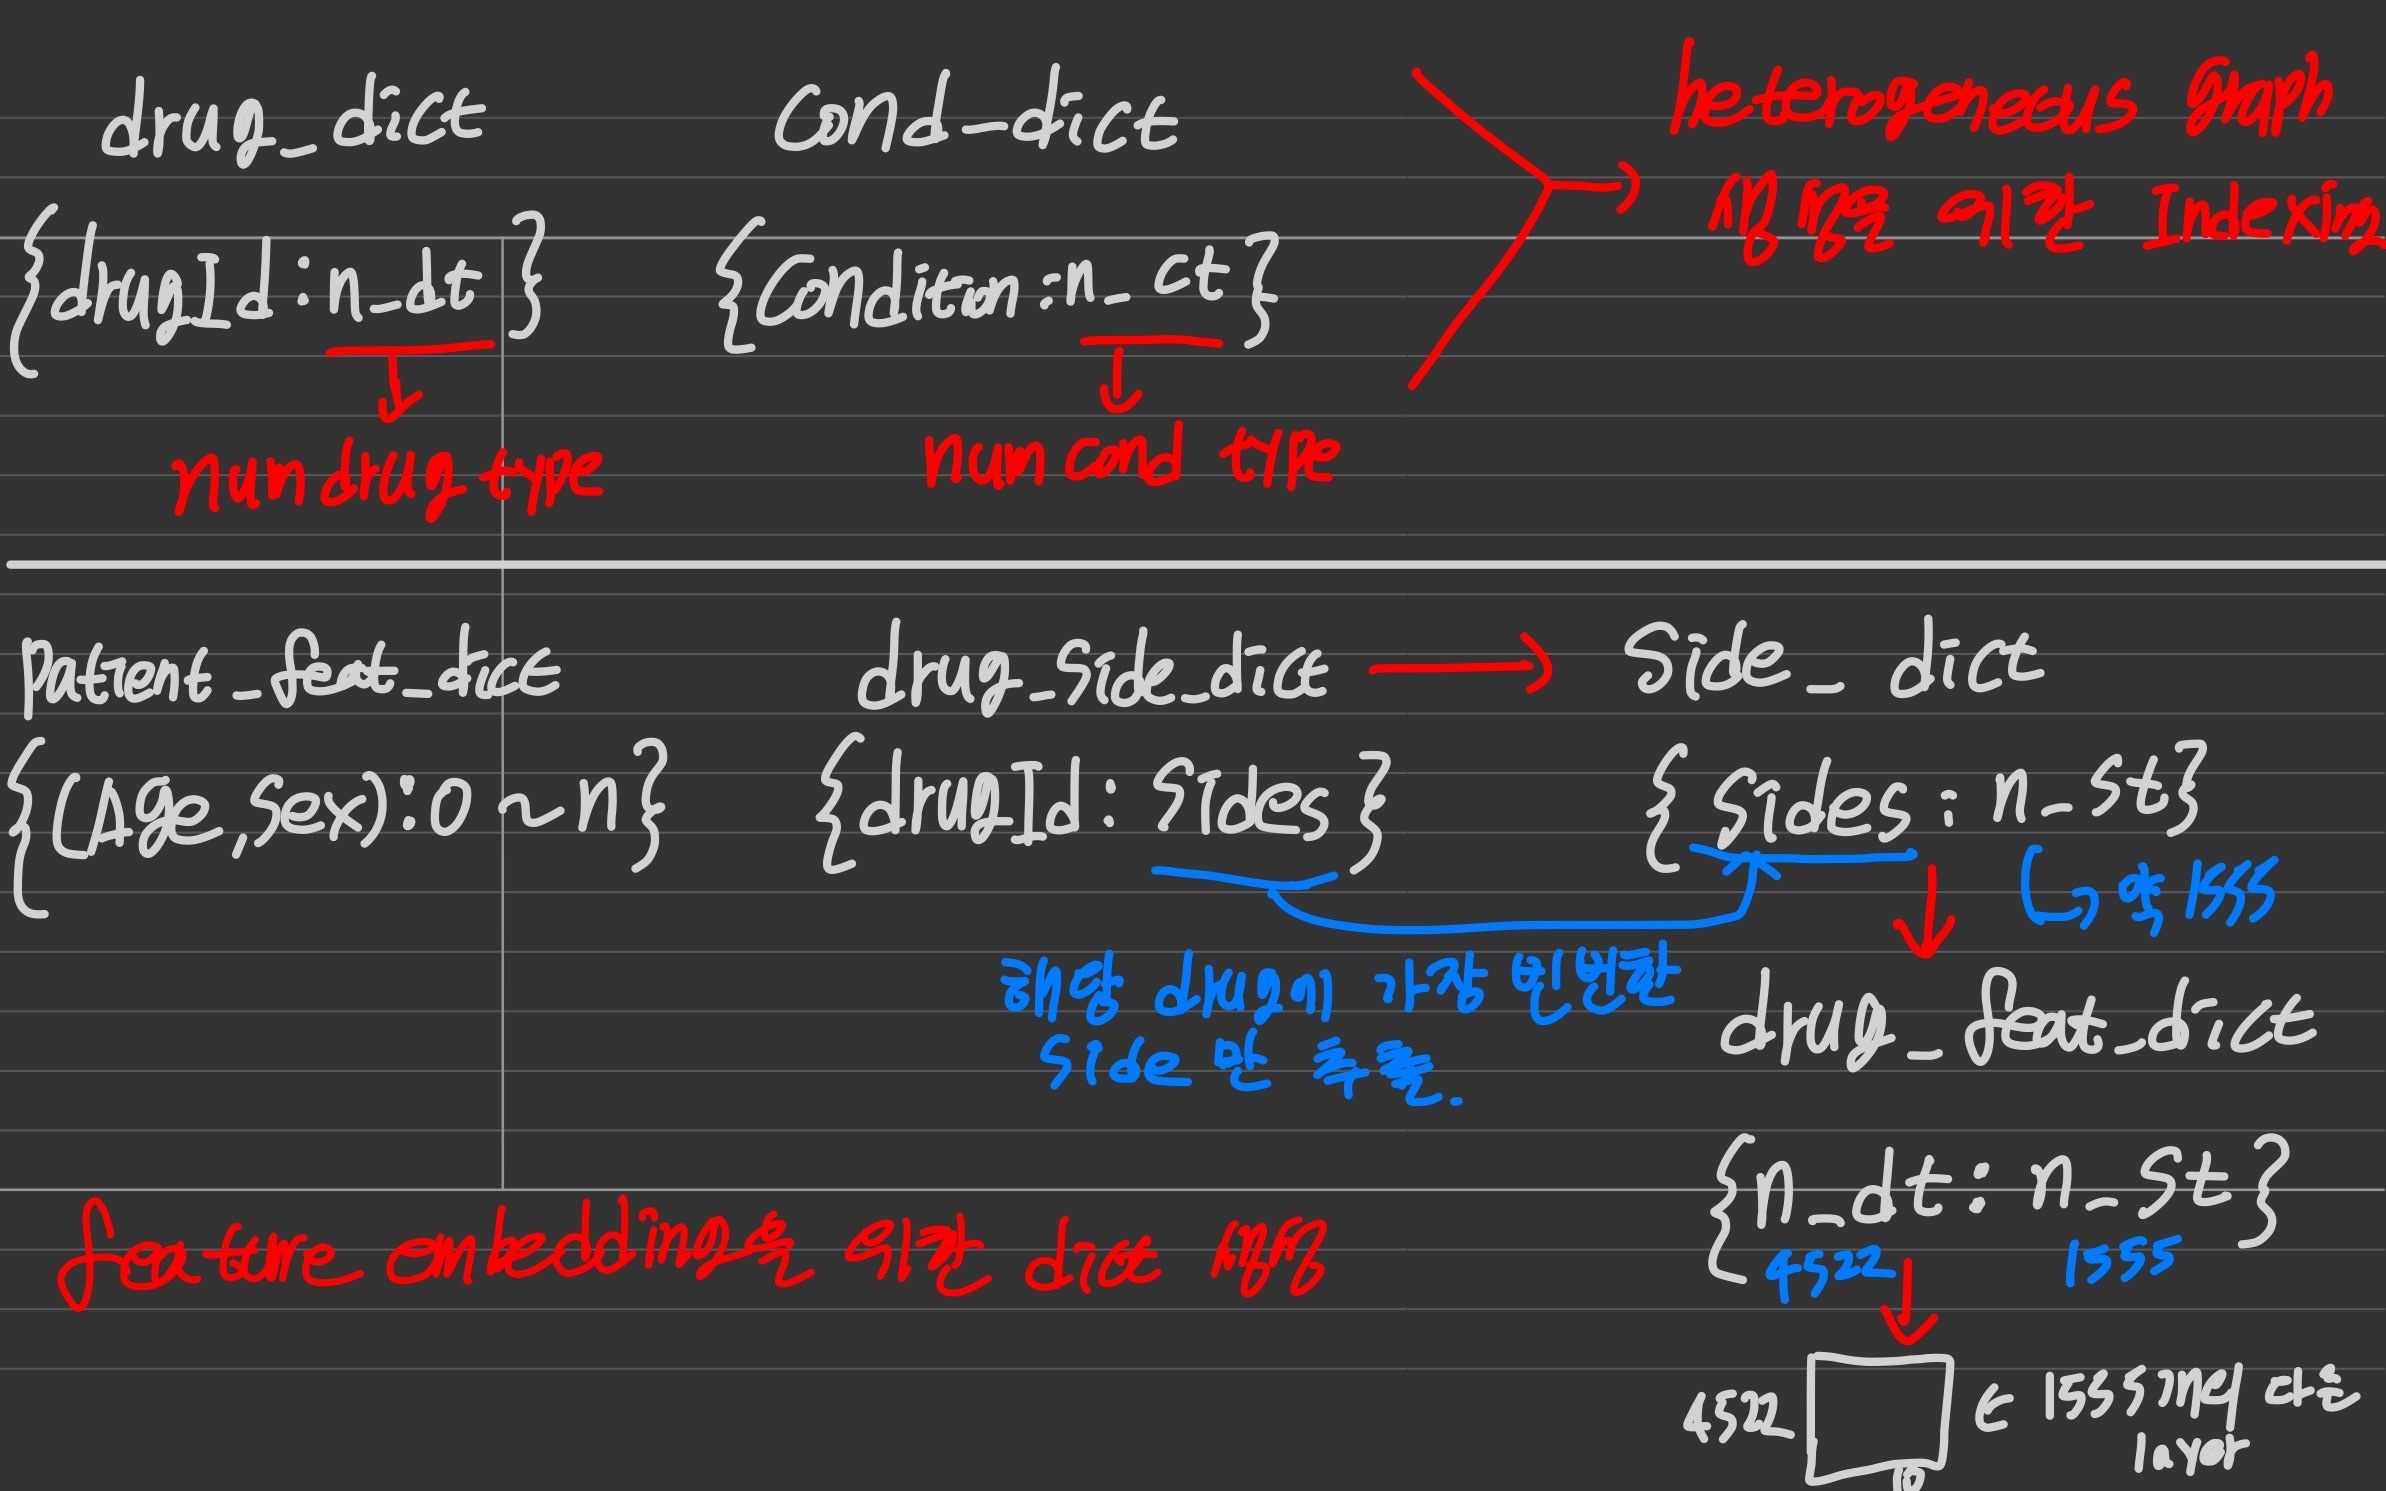
</div>


In [14]:
### Drug Feature

# drug_side_dict
drug_side_dict = {}

for i in drug_dict.keys():
    most_side = df_[df_['DrugId']==i]['Sides'].value_counts().index[0]
    drug_side_dict[i] = most_side


# side_dict (Cause of sides duplicate, using set)
side_dict = {}
index = 0
side_set = set()
side_set.update(drug_side_dict.values())

for j in side_set:
    side_dict[j] = index
    index += 1


# drug_feat_dict
drug_feat_dict = {}

for i in drug_side_dict.keys():
    drug_feat_dict[drug_dict[i]] = side_dict[drug_side_dict[i]]

In [15]:
# embedding features
def get_embed(dictionary, lst, embed_n):
    num_lst = [int(dictionary[i]) for i in lst]

    embedding_table = nn.Embedding(num_embeddings=len(dictionary.keys()), 
                               embedding_dim=embed_n)

    embed_feat = embedding_table(torch.LongTensor(num_lst))

    return embed_feat

In [16]:
# patient embedding
patient_embed = get_embed(patient_feat_dict, patient_f_lst, 10)

# condition embedding
cond_embed_table = nn.Embedding(num_embeddings=len(set(cond_dict.values())), 
                               embedding_dim=10)
condition_embed = cond_embed_table(torch.LongTensor(cond_f_lst))


# drug embedding
embedding_table = nn.Embedding(num_embeddings=len(set(drug_feat_dict.values())), 
                               embedding_dim=10)
drug_embed = embedding_table(torch.LongTensor(list(drug_feat_dict.values())))

In [17]:
condition_embed.shape

torch.Size([280127, 10])

In [18]:
print('Patient')
print(patient_embed)

print('------------------')
print('Drug')
print(drug_embed)

Patient
tensor([[ 1.6674, -0.8292, -1.7540,  ...,  1.1914, -0.6961, -1.4534],
        [ 0.1110, -0.0557, -0.3174,  ...,  1.9730,  0.1765, -1.4036],
        [ 0.1110, -0.0557, -0.3174,  ...,  1.9730,  0.1765, -1.4036],
        ...,
        [ 0.1110, -0.0557, -0.3174,  ...,  1.9730,  0.1765, -1.4036],
        [ 0.6779, -0.4359,  0.5132,  ..., -1.9997,  0.3171,  0.7568],
        [ 0.1198,  1.6811, -0.3244,  ..., -0.6026,  0.9054, -1.2379]],
       grad_fn=<EmbeddingBackward>)
------------------
Drug
tensor([[-0.6277,  0.1193, -0.2364,  ..., -0.2561, -0.6957,  0.9467],
        [-0.1919, -1.6456,  0.8805,  ..., -0.0258, -0.1062, -0.6027],
        [-1.0384,  0.5700, -1.0440,  ...,  1.1613,  0.2095, -0.5962],
        ...,
        [ 0.4116, -1.4129,  0.2591,  ..., -0.6329,  1.1148, -0.7974],
        [ 0.7466,  0.9643, -0.4995,  ...,  1.8391, -1.2894,  0.4528],
        [-0.6896, -0.9274, -1.2776,  ..., -0.1155,  1.0922,  0.1676]],
       grad_fn=<EmbeddingBackward>)


### split drug / patient / label


In [19]:
patient_df = df_[['patient_id', 'Age', 'Sex']]
condition_df = df_[['Condition']]
drug_df = df_[['DrugId', 'Sides']]
label = df_[['Satisfaction']]
p_d_edge_features = df_[['EaseofUse', 'UsefulCount']]
d_c_edge_features = df_[['Effectiveness']]

<div>
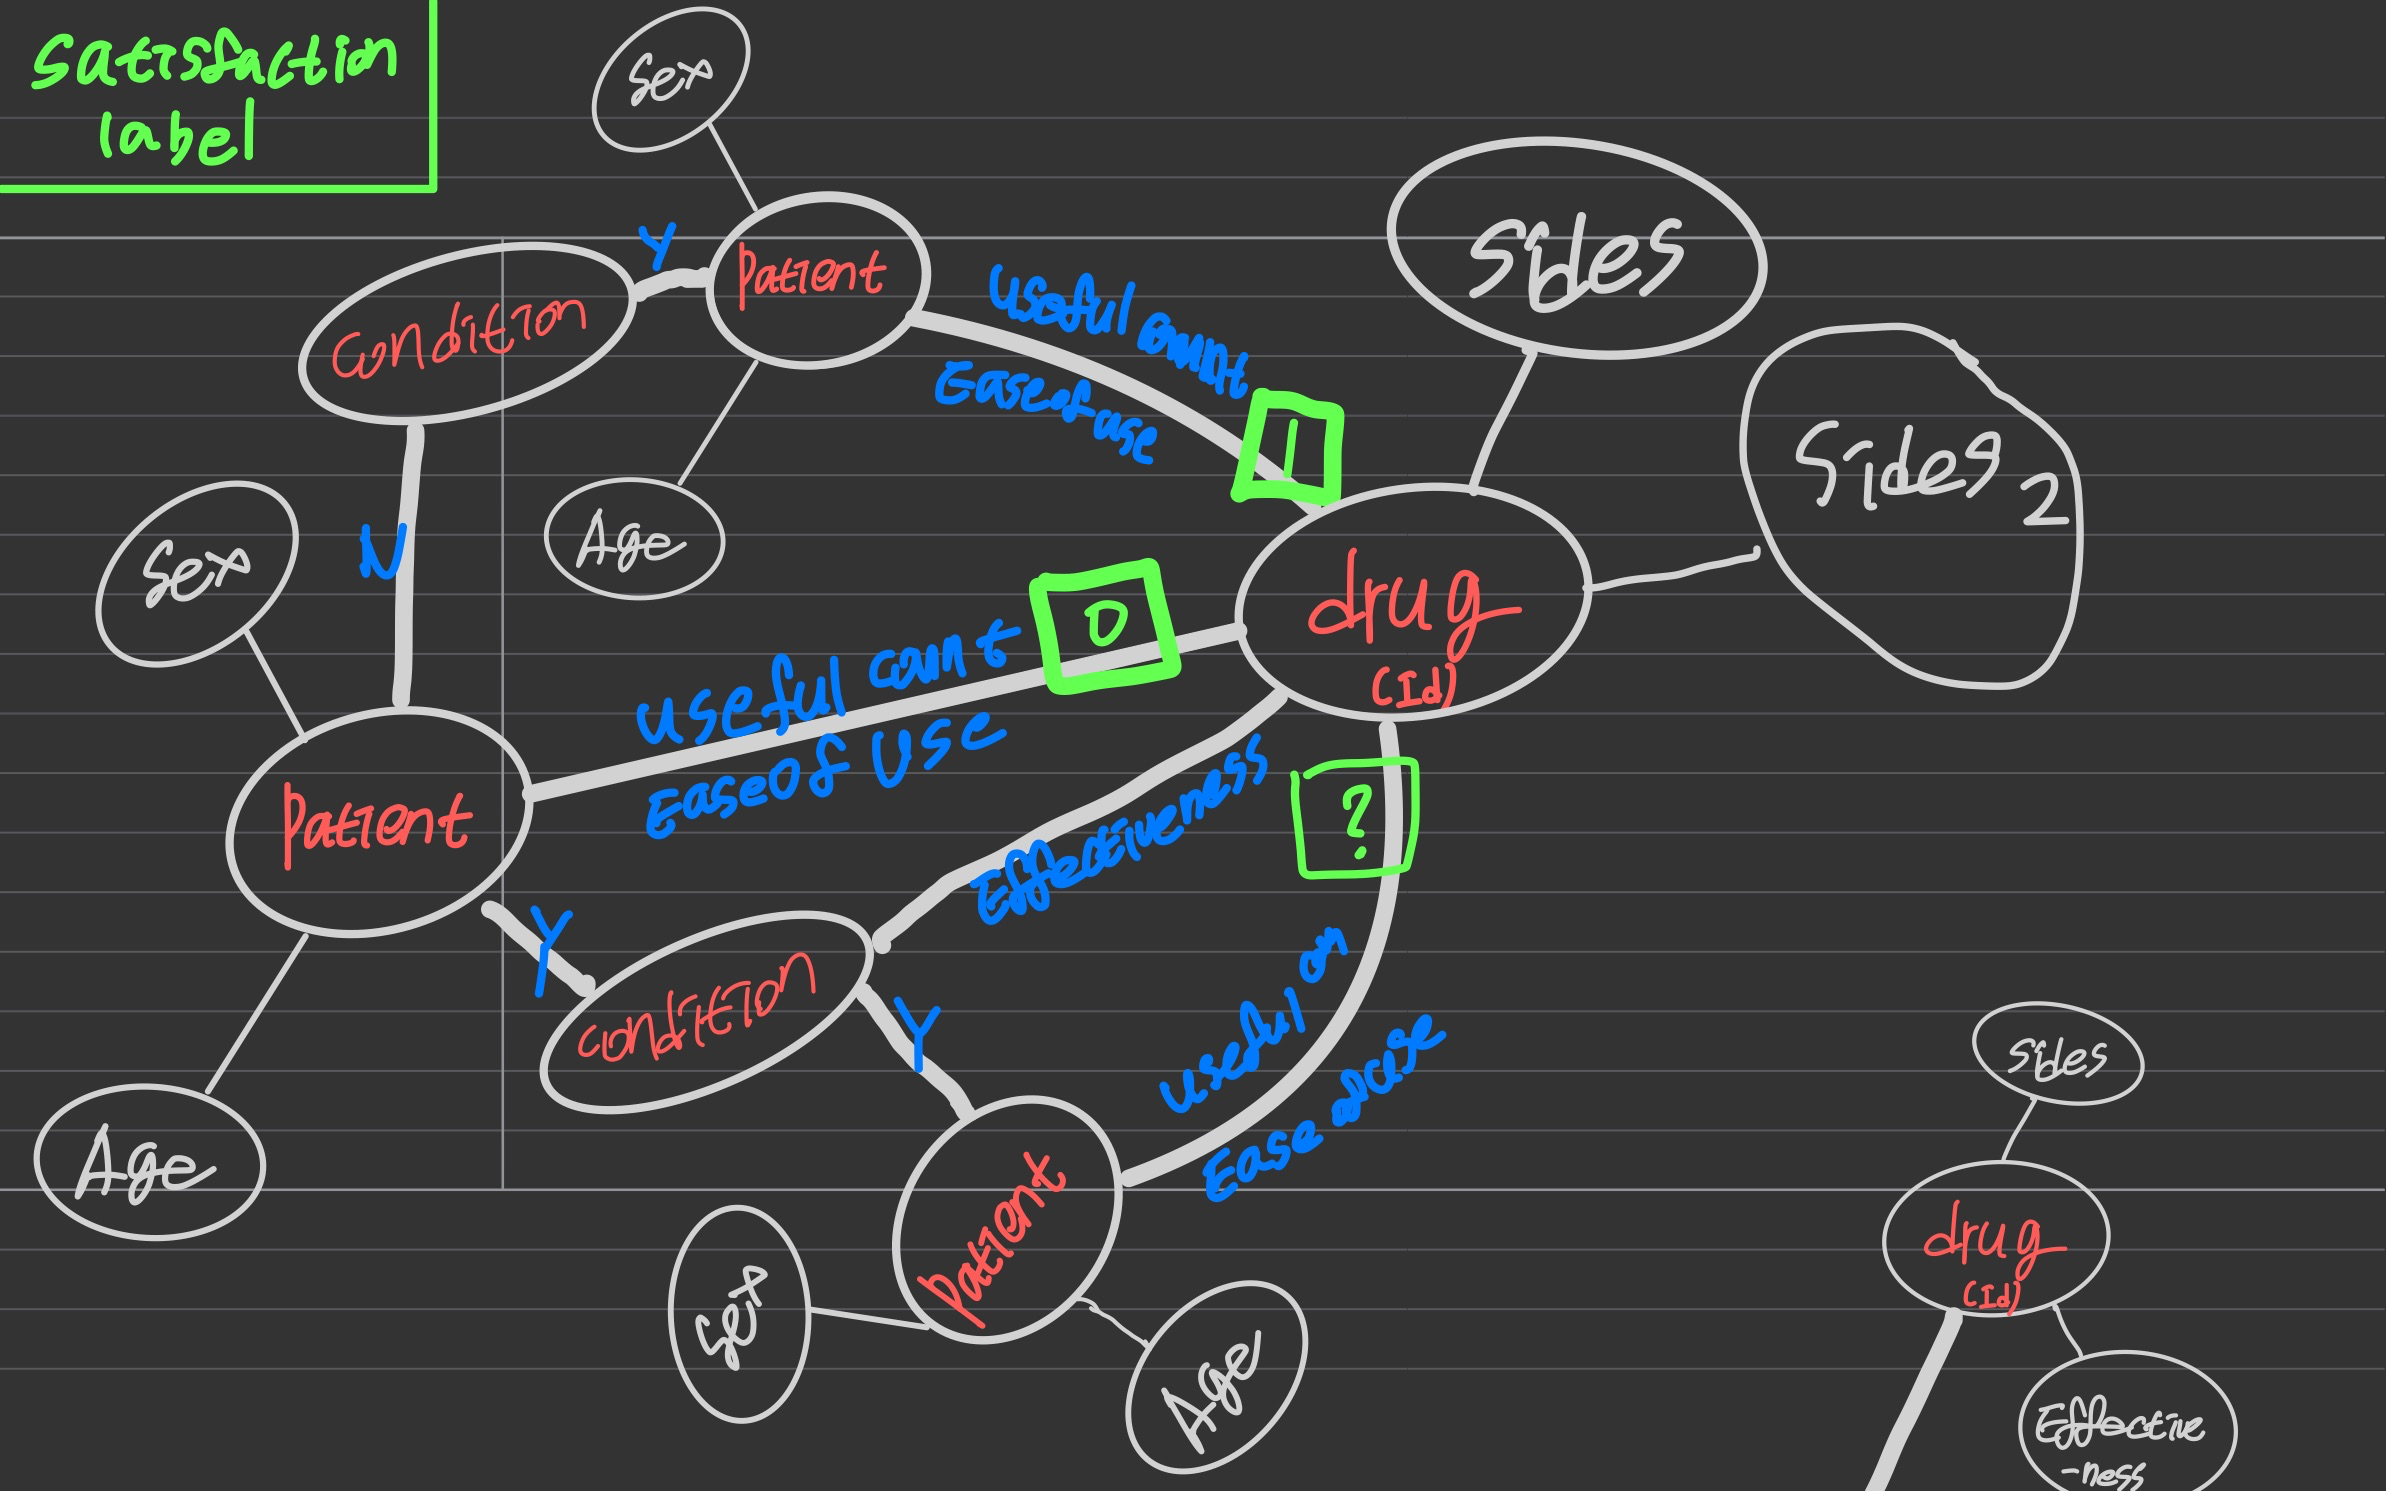
</div>

### Create Heterogeneous Graph

In [20]:
df_['EaseofUse']

0         1
1         1
2         1
3         1
4         1
         ..
280122    0
280123    1
280124    0
280125    1
280126    1
Name: EaseofUse, Length: 280127, dtype: int64

In [21]:
def get_n_arr(dataframe, dictionary, column):    
    num_lst = [int(dictionary[i]) for i in dataframe[column]]
    
    return np.array(num_lst)

# arr list
""" 
patient_arr / drug_arr / cond_arr
"""

patient_arr = np.array(df_['patient_id'])
drug_arr = get_n_arr(df_, drug_dict, 'DrugId')
cond_arr = get_n_arr(df_, cond_dict, 'Condition')

label_arr = torch.tensor(df_['Satisfaction'])

- node : [`patient`, `drug`, `condition`]
- edge : 
  - (`patient`, `satisfaction`, `drug`) : `label`
  - (`condition`, `symptom`, `patient`)
  - (`drug`, `Effectiveness`, `condition`)

### train / Inference data

In [22]:
df_.shape

(280127, 13)

In [23]:
train_bool = torch.zeros(len(df_), dtype=torch.bool).bernoulli(0.9)
inf_bool = ~train_bool

In [24]:
train_index = df_.iloc[patient_arr[train_bool],:].index
print(len(train_index))
train_index

252051


Int64Index([     0,      2,      3,      5,      6,      7,      8,      9,
                10,     12,
            ...
            280116, 280117, 280118, 280119, 280120, 280121, 280122, 280123,
            280124, 280125],
           dtype='int64', length=252051)

In [25]:
inf_index = df_.iloc[patient_arr[inf_bool],:].index
print(len(inf_index))
inf_index

28076


Int64Index([     1,      4,     11,     14,     17,     19,     44,     51,
                55,     57,
            ...
            280026, 280031, 280035, 280051, 280063, 280067, 280097, 280105,
            280110, 280126],
           dtype='int64', length=28076)

In [26]:
df_t = df_.iloc[train_index, :]
df_inf = df_.iloc[inf_index, :]

In [27]:
df_t['patient_id'] = [i for i in range(len(df_t))]
df_t = df_t.reset_index(drop=True)

df_inf['patient_id'] = [i for i in range(len(df_inf))]
df_inf = df_inf.reset_index(drop=True)

<ipython-input-27-a90c972e791e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['patient_id'] = [i for i in range(len(df_t))]
<ipython-input-27-a90c972e791e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['patient_id'] = [i for i in range(len(df_inf))]


<div>
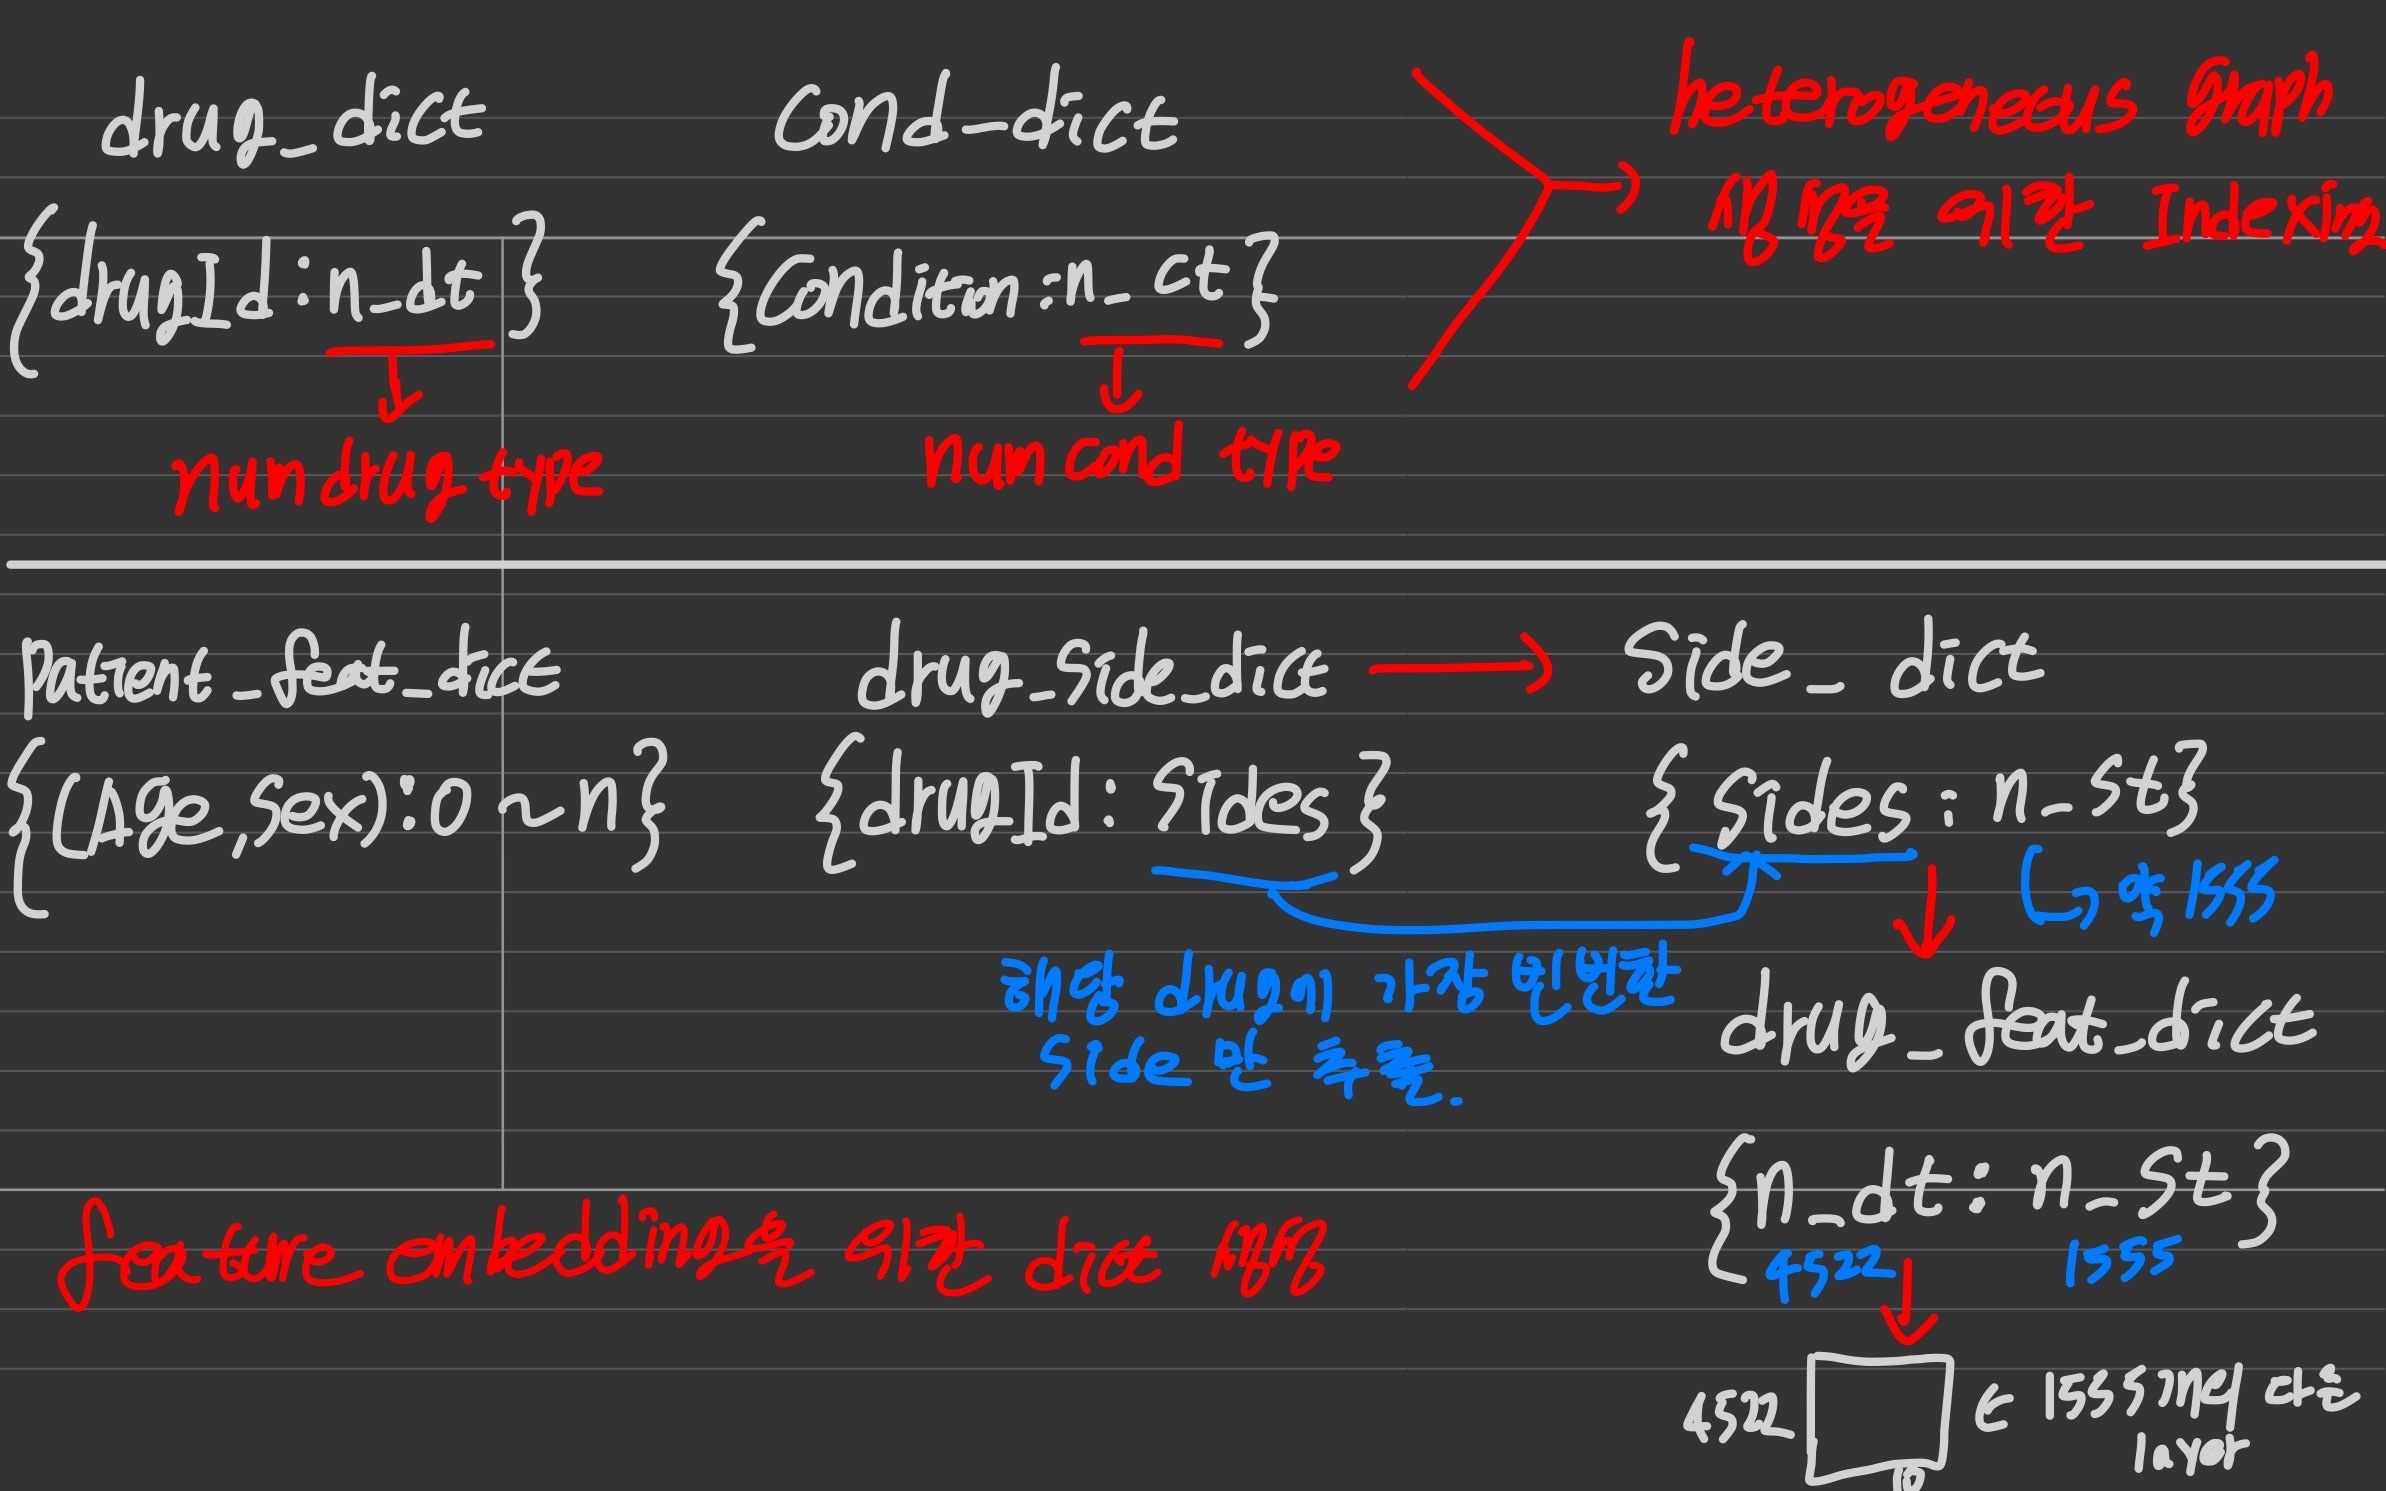
</div>


- drug_side_dict : 가장 빈번한 Side Effect 를 매칭시키기 위한 dictionary
    - **different drug -> same side**
- side_dict : 위에서 정의된 Side Effect 인덱스 번호

In [28]:
### train array
patient_arr_t = np.array(df_t['patient_id'])
drug_arr_t = get_n_arr(df_t, drug_dict, 'DrugId')
cond_arr_t = get_n_arr(df_t, cond_dict, 'Condition')

label_arr_t = torch.tensor(list(df_t['Satisfaction']))




In [29]:
### TRAIN data
hetero_graph_t = dgl.heterograph({
    ('patient', 'satisfaction', 'drug'): (patient_arr_t, drug_arr_t),
    ('condition', 'symptom', 'patient'): (cond_arr_t, patient_arr_t),
    ('drug', 'Easy', 'patient'): (drug_arr_t[df_t['EaseofUse']==1], patient_arr_t[df_t['EaseofUse']==1]),
    ('drug', 'Effectiveness', 'condition'): (drug_arr_t[df_t['Effectiveness']==1], cond_arr_t[df_t['Effectiveness']==1])
      })



In [30]:
# node feature
## patient 는 key 값을 기준으로 embedding table의 row갯수 생성

# train patient embedding
patient_feat_lst_t = [(df_t['Age'][i], df_t['Sex'][i]) for i in range(len(df_t))]
patient_embed_t = get_embed(patient_feat_dict, patient_feat_lst_t, 10)  



# condition embedding

## train / inference 공통의 embedding table 이용
cond_embed_table = nn.Embedding(num_embeddings=len(set(cond_dict.values())), 
                               embedding_dim=10)

# train condition embedding
cond_lst_t = [i for i in range(max(cond_arr_t)+1)]
cond_embed_t = cond_embed_table(torch.LongTensor(cond_lst_t))



### drug_embed_table
## drug 는 value(sides) 기준으로 embedding table의 row 갯수 생성
## ==>즉 drug 타입은 달라도 같은 Sides 를 가지는 경우 존재

# 공통으로 쓰일 embedding table
drug_embed_table = nn.Embedding(
                                num_embeddings=len(set(drug_feat_dict.values())),
                                embedding_dim=10)


# train_drug_feature embedding
drug_embed_t = drug_embed_table(torch.LongTensor([drug_feat_dict[i] for i in range(hetero_graph_t.num_nodes('drug'))]))



In [31]:
hetero_graph_t

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 252051},
      num_edges={('condition', 'symptom', 'patient'): 252051, ('drug', 'Easy', 'patient'): 186736, ('drug', 'Effectiveness', 'condition'): 147611, ('patient', 'satisfaction', 'drug'): 252051},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [33]:
## node feature and labeling

# train data
hetero_graph_t.edges['satisfaction'].data['label'] = label_arr_t
hetero_graph_t.nodes['patient'].data['feature'] = patient_embed_t
hetero_graph_t.nodes['drug'].data['feature'] = drug_embed_t
hetero_graph_t.nodes['condition'].data['feature'] = cond_embed_t

In [34]:
hetero_graph_t

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 252051},
      num_edges={('condition', 'symptom', 'patient'): 252051, ('drug', 'Easy', 'patient'): 186736, ('drug', 'Effectiveness', 'condition'): 147611, ('patient', 'satisfaction', 'drug'): 252051},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [35]:
hetero_graph_inf

Graph(num_nodes={'condition': 1583, 'drug': 4521, 'patient': 28076},
      num_edges={('condition', 'symptom', 'patient'): 28076, ('drug', 'Easy', 'patient'): 20848, ('drug', 'Effectiveness', 'condition'): 16538, ('patient', 'satisfaction', 'drug'): 28076},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

### model

In [36]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')


    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [38]:
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__() 
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['h'], edges.dst['h']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [39]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names, bi_pred=False):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        
        if bi_pred==False:
            self.pred = HeteroMLPPredictor(out_features, len(rel_names))
        else:
            self.pred = HeteroMLPPredictor(out_features, 2)
        
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        h_2 = {'drug': h['drug'], 'patient': h['patient']}
        return self.pred(dec_graph, h_2)

### Masking Task

In [40]:
# edge length
num_edges = len(hetero_graph_t.edata['label'][('patient', 'satisfaction', 'drug')])

train_mask = torch.zeros(num_edges, dtype=torch.bool).bernoulli(0.8)
val_mask = ~train_mask

In [41]:
train_mask

tensor([ True, False,  True,  ...,  True, False,  True])

In [42]:
len(label_arr_t[train_mask])

202061

In [45]:
dec_graph_t = hetero_graph_t['patient', :, 'drug']

label_arr_t = torch.tensor(list(df_t['Satisfaction']))

model = Model(10, 20, 5, hetero_graph_t.etypes, 1)

patient_feats_t = hetero_graph_t.nodes['patient'].data['feature']
drug_feats_t = hetero_graph_t.nodes['drug'].data['feature']
cond_feats_t = hetero_graph_t.nodes['condition'].data['feature']

node_features_t = {'patient': patient_feats_t, 'drug': drug_feats_t, 'condition': cond_feats_t}

dec_graph_t = hetero_graph_t['patient', :, 'drug']

opt = torch.optim.Adam(model.parameters())

for epoch in range(300):
    logits = model(hetero_graph_t, node_features_t, dec_graph_t)
    loss = F.cross_entropy(logits[train_mask], label_arr_t[train_mask])
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

    if epoch % 5 == 0:
        acc_val = torchmetrics.functional.accuracy(logits[val_mask], label_arr_t[val_mask])
        print(f"--------- {epoch} ---------")
        print('val_acc : ', acc_val)

--------- 0 ---------
val_acc :  tensor(0.4843)
--------- 5 ---------
val_acc :  tensor(0.5157)
--------- 10 ---------
val_acc :  tensor(0.5300)
--------- 15 ---------
val_acc :  tensor(0.5423)
--------- 20 ---------
val_acc :  tensor(0.5521)
--------- 25 ---------
val_acc :  tensor(0.5615)
--------- 30 ---------
val_acc :  tensor(0.5747)
--------- 35 ---------
val_acc :  tensor(0.5904)
--------- 40 ---------
val_acc :  tensor(0.5990)
--------- 45 ---------
val_acc :  tensor(0.6075)
--------- 50 ---------
val_acc :  tensor(0.6204)
--------- 55 ---------
val_acc :  tensor(0.6276)
--------- 60 ---------
val_acc :  tensor(0.6319)
--------- 65 ---------
val_acc :  tensor(0.6376)
--------- 70 ---------
val_acc :  tensor(0.6392)
--------- 75 ---------
val_acc :  tensor(0.6444)
--------- 80 ---------
val_acc :  tensor(0.6473)
--------- 85 ---------
val_acc :  tensor(0.6507)
--------- 90 ---------
val_acc :  tensor(0.6538)
--------- 95 ---------
val_acc :  tensor(0.6570)
--------- 100 --------

### Inference

In [46]:
df_inf.head()

Age                         Condition        Date  \
0  25-34                     Cold Symptoms   1/13/2011   
1  55-64                       Stuffy Nose  10/29/2012   
2  25-34                     Birth Control    9/4/2015   
3  45-54                     Birth Control  11/14/2014   
4  35-44  Abnormally Long or Heavy Periods   9/12/2017   

                                      Drug  DrugId  EaseofUse  Effectiveness  \
0                             25dph-7.5peh  146724          1              1   
1  12 hour nasal relief spray, non-aerosol    9800          1              0   
2                                     lyza  164750          0              1   
3                                     lyza  164750          0              1   
4                                  lysteda  154120          1              1   

                                             Reviews  Satisfaction     Sex  \
0  cleared me right up even with my throat hurtin...             1  Female   
1   The 12 hour spray only works for me for 6 hours.             0    Male   
2  Right after starting this pill I began gaining...             0  Female   
3  After losing 25 lbs over the last two years, I...             0  Female   
4  Not a miracle, but a definite game changer. Th...             1  Female   

                                               Sides  UsefulCount  patient_id  
0  Drowsiness,  dizziness ,  dry mouth /nose/thro...            1           0  
1  Temporary burning, stinging, dryness in the no...            0           1  
2  Nausea ,  vomiting ,  headache ,  bloating ,  ...            3           2  
3  Nausea ,  vomiting ,  headache ,  bloating ,  ...            5           3  
4  Nausea ,  vomiting ,  diarrhea , and  muscle p...            0           4

In [135]:

### inference array
patient_arr_inf = np.array(df_inf['patient_id'])
drug_arr_inf = get_n_arr(df_inf, drug_dict, 'DrugId')
cond_arr_inf = get_n_arr(df_inf, cond_dict, 'Condition')

label_arr_inf = torch.tensor(list(df_inf['Satisfaction']))


### INFERENCE data
hetero_graph_inf = dgl.heterograph({
    ('patient', 'satisfaction', 'drug'): (patient_arr_inf, drug_arr_inf),
    ('condition', 'symptom', 'patient'): (cond_arr_inf, patient_arr_inf),
    ('drug', 'Easy', 'patient'): (drug_arr_inf[df_inf['EaseofUse']==1], patient_arr_inf[df_inf['EaseofUse']==1]),
    ('drug', 'Effectiveness', 'condition'): (drug_arr_inf[df_inf['Effectiveness']==1], cond_arr_inf[df_inf['Effectiveness']==1])
      })

In [136]:
# inference patient embedding 
patient_feat_lst_inf = [(df_inf['Age'][i], df_inf['Sex'][i]) for i in range(len(df_inf))]
patient_embed_inf = get_embed(patient_feat_dict, patient_feat_lst_inf, 10)


# inference condition embedding
cond_lst_inf = [i for i in range(max(cond_arr_inf)+1)]
cond_embed_inf = cond_embed_table(torch.LongTensor(cond_lst_inf))


# inference_drug_feature embedding
drug_embed_inf = drug_embed_table(torch.LongTensor([drug_feat_dict[i] for i in range(hetero_graph_inf.num_nodes('drug'))]))


In [137]:
# inference data
hetero_graph_inf.edges['satisfaction'].data['label'] = label_arr_inf
hetero_graph_inf.nodes['patient'].data['feature'] = patient_embed_inf
hetero_graph_inf.nodes['drug'].data['feature'] = drug_embed_inf
hetero_graph_inf.nodes['condition'].data['feature'] = cond_embed_inf

In [138]:
dec_graph_inf = hetero_graph_inf['patient', :, 'drug']

label_arr_inf = torch.tensor(list(df_inf['Satisfaction']))

# model = Model(10, 20, 5, hetero_graph_inf.etypes, 1)

patient_feats_inf = hetero_graph_inf.nodes['patient'].data['feature']
drug_feats_inf = hetero_graph_inf.nodes['drug'].data['feature']
cond_feats_inf = hetero_graph_inf.nodes['condition'].data['feature']

node_features_inf = {'patient': patient_feats_inf, 'drug': drug_feats_inf, 'condition': cond_feats_inf}

dec_graph_inf = hetero_graph_inf['patient', :, 'drug']


In [139]:
dec_graph_inf

Graph(num_nodes={'patient': 28076, 'drug': 4521},
      num_edges={('patient', 'satisfaction', 'drug'): 28076},
      metagraph=[('patient', 'drug', 'satisfaction')])

In [140]:
model.eval()

with torch.no_grad():
    test_logit = model(hetero_graph_inf, node_features_inf, dec_graph_inf)
test_logit

tensor([[ 0.8411, -0.7494],
        [-0.7288, -0.0263],
        [ 0.8799, -0.6896],
        ...,
        [ 0.9892, -0.3838],
        [ 0.1877,  0.0109],
        [ 0.1877,  0.0109]])

In [141]:
torch.argmax(test_logit, dim=1).shape

torch.Size([28076])

In [142]:
torchmetrics.functional.accuracy(test_logit, label_arr_inf)

tensor(0.5956)

In [143]:
test_logit.shape

torch.Size([28076, 2])

In [144]:
label_arr_inf.shape

torch.Size([28076])

### inf_test

In [358]:
df_t.shape

(252171, 13)

In [52]:
hetero_graph_t

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 252051},
      num_edges={('condition', 'symptom', 'patient'): 252051, ('drug', 'Easy', 'patient'): 186736, ('drug', 'Effectiveness', 'condition'): 147611, ('patient', 'satisfaction', 'drug'): 252051},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [53]:
hetero_graph_inf

Graph(num_nodes={'condition': 1583, 'drug': 4521, 'patient': 28076},
      num_edges={('condition', 'symptom', 'patient'): 28076, ('drug', 'Easy', 'patient'): 20848, ('drug', 'Effectiveness', 'condition'): 16538, ('patient', 'satisfaction', 'drug'): 28076},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [72]:
df_test = df_.iloc[hetero_graph_t.num_nodes('patient'):, :]

In [73]:
### added_inference array
patient_arr_inf = np.array(df_test['patient_id'])
drug_arr_inf = get_n_arr(df_test, drug_dict, 'DrugId')
cond_arr_inf = get_n_arr(df_test, cond_dict, 'Condition')

label_arr_inf = torch.tensor(list(df_test['Satisfaction']))

In [74]:
patient_arr_t

array([     0,      1,      2, ..., 252048, 252049, 252050])

In [75]:
patient_arr_inf

array([252051, 252052, 252053, ..., 280124, 280125, 280126])

In [81]:
### add edges
hetero_graph_inf = dgl.add_edges(hetero_graph_t, patient_arr_inf, drug_arr_inf, etype='satisfaction')
hetero_graph_inf = dgl.add_edges(hetero_graph_inf, cond_arr_inf, patient_arr_inf, etype='symptom')
hetero_graph_inf = dgl.add_edges(hetero_graph_inf, drug_arr_inf[df_test['EaseofUse']==1], patient_arr_inf[df_test['EaseofUse']==1], etype='Easy')
hetero_graph_inf = dgl.add_edges(hetero_graph_inf, drug_arr_inf[df_test['Effectiveness']==1], cond_arr_inf[df_test['Effectiveness']==1], etype='Effectiveness')

In [82]:
hetero_graph_inf

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 280127},
      num_edges={('condition', 'symptom', 'patient'): 280127, ('drug', 'Easy', 'patient'): 206566, ('drug', 'Effectiveness', 'condition'): 164094, ('patient', 'satisfaction', 'drug'): 280127},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [83]:
hetero_graph_t

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 252051},
      num_edges={('condition', 'symptom', 'patient'): 252051, ('drug', 'Easy', 'patient'): 186736, ('drug', 'Effectiveness', 'condition'): 147611, ('patient', 'satisfaction', 'drug'): 252051},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [84]:
# feature embedding
patient_feat_lst_inf  = [(df_['Age'][i], df_['Sex'][i]) for i in df_.index]
patient_embed_inf = get_embed(patient_feat_dict, patient_feat_lst_inf, 10)

cond_embed_inf = cond_embed_table(torch.LongTensor([i for i in range(hetero_graph_inf.num_nodes('condition'))]))

drug_embed_inf = drug_embed_table(torch.LongTensor([drug_feat_dict[i] for i in range(hetero_graph_inf.num_nodes('drug'))]))

In [85]:
df_.shape

(280127, 13)

In [86]:
hetero_graph_inf

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 280127},
      num_edges={('condition', 'symptom', 'patient'): 280127, ('drug', 'Easy', 'patient'): 206566, ('drug', 'Effectiveness', 'condition'): 164094, ('patient', 'satisfaction', 'drug'): 280127},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [87]:
## node feature and labeling
label_arr_inf = torch.tensor(list(df_['Satisfaction']))

# inference data
hetero_graph_inf.edges['satisfaction'].data['label'] = label_arr_inf
hetero_graph_inf.nodes['patient'].data['feature'] = patient_embed_inf
hetero_graph_inf.nodes['drug'].data['feature'] = drug_embed_inf
hetero_graph_inf.nodes['condition'].data['feature'] = cond_embed_inf

In [88]:
hetero_graph_inf

Graph(num_nodes={'condition': 1584, 'drug': 4522, 'patient': 280127},
      num_edges={('condition', 'symptom', 'patient'): 280127, ('drug', 'Easy', 'patient'): 206566, ('drug', 'Effectiveness', 'condition'): 164094, ('patient', 'satisfaction', 'drug'): 280127},
      metagraph=[('condition', 'patient', 'symptom'), ('patient', 'drug', 'satisfaction'), ('drug', 'patient', 'Easy'), ('drug', 'condition', 'Effectiveness')])

In [89]:
patient_feats_inf = hetero_graph_inf.nodes['patient'].data['feature']
drug_feats_inf = hetero_graph_inf.nodes['drug'].data['feature']
cond_feats_inf = hetero_graph_inf.nodes['condition'].data['feature']

node_features_inf = {'patient': patient_feats_inf, 'drug': drug_feats_inf, 'condition': cond_feats_inf}


In [90]:
node_features_inf = {'patient': patient_feats_inf, 'drug': drug_feats_inf, 'condition': cond_feats_inf}

dec_graph_inf = hetero_graph_inf['patient', :, 'drug']


In [91]:
model.eval()

with torch.no_grad():
    test_logit = model(hetero_graph_inf, node_features_inf, dec_graph_inf)
test_logit

tensor([[-0.0955, -0.1507],
        [-1.4347,  0.0068],
        [-1.4483,  0.0267],
        ...,
        [ 1.6869, -0.0905],
        [ 0.4312,  0.5608],
        [ 0.4312,  0.5608]])

In [105]:
start = hetero_graph_t.num_nodes('patient')
torch.argmax(test_logit, dim=1)[start : start+100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1])

In [112]:
count=0
for i in label_arr_inf:
    if i ==1:
        count+=1
print(count)

131335


In [109]:
label_arr_inf[start : start+100]

tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0])

In [117]:
torchmetrics.functional.accuracy(test_logit[start:], label_arr_inf[start:])

tensor(0.6516)

### etc

- `side effect` 는 나누어서 컬럼으로 부여

In [ ]:
df_sides = df_['Sides'].str.split(',')
df_sides = pd.DataFrame(df_sides.tolist())
df_sides.columns = ['side'+ str(i) for i in range(17)]
df_sides.head()

In [97]:
patient_fea = df_[['Age', 'Sex']]
fea_df = pd.concat([patient_fea, df_sides], axis=1)
fea_df.head()

Age     Sex              side0         side1  \
0  75 or over    Male         Drowsiness    dizziness    
1       25-34  Female         Drowsiness    dizziness    
2       25-34  Female            Nausea      vomiting    
3       45-54  Female            Nausea      vomiting    
4       55-64    Male  Temporary burning      stinging   

                      side2          side3                       side4  \
0    dry mouth /nose/throat      headache               upset stomach    
1    dry mouth /nose/throat      headache               upset stomach    
2                 headache       bloating           breast  tenderness   
3                 headache       bloating           breast  tenderness   
4       dryness in the nose    runny nose    and  sneezing  may occur.   

                                              side5  \
0                                     constipation    
1                                     constipation    
2   swelling of the  ankles /feet (fluid retention)   
3   swelling of the  ankles /feet (fluid retention)   
4                                              None   

                               side6 side7 side8 side9 side10 side11 side12  \
0   or  trouble sleeping  may occur.  None  None  None   None   None   None   
1   or  trouble sleeping  may occur.  None  None  None   None   None   None   
2      or  weight  change may occur.  None  None  None   None   None   None   
3      or  weight  change may occur.  None  None  None   None   None   None   
4                               None  None  None  None   None   None   None   

  side13 side14 side15 side16  
0   None   None   None   None  
1   None   None   None   None  
2   None   None   None   None  
3   None   None   None   None  
4   None   None   None   None

### train/val/test Split

In [60]:
label_df = df_[['Satisfaction']]
x = df_.drop('Satisfaction', axis=1)

In [459]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, label_df, test_size=0.2, random_state=123, stratify=label_df)

In [462]:
x_train['Satisfaction'] = y_train

<ipython-input-462-253896d4273d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Satisfaction'] = y_train
